In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import defaultdict

In [32]:
class GridWorld:
    def __init__(
        self, 
        size=4,
        terminal_states=((0,0), (3,3)), 
        reward=-1
    ):
        self.size = size
        self.state_space = size * size
        self.terminal_states = terminal_states
        self.reward = reward
        self.actions = ('U', 'D', 'L', 'R')
        self.action_space = len(self.actions)
        self.reset()

    def is_terminal(self, state):
        return state in self.terminal_states
    
    def reset(self):
        self.state = (np.random.randint(self.size), np.random.randint(self.size))
        while self.state in self.terminal_states:
            self.state = (np.random.randint(self.size), np.random.randint(self.size))
        return self.state

    def step(self, action):
        if self.is_terminal(self.state):
            return self.state, 0, True

        x, y = self.state
        if action == 'U': x = max(x - 1, 0)
        if action == 'D': x = min(x + 1, self.size - 1)
        if action == 'L': y = max(y - 1, 0)
        if action == 'R': y = min(y + 1, self.size - 1)
        self.state = (x, y)
        
        return self.state, self.reward, self.is_terminal(self.state)


def eps_greedy_policy(env, state, Q, eps):
    """
    epsilon-greedy policy
    """

    if np.random.random() < eps:
        return np.random.choice(env.actions)
    
    state_action_values = {a: Q[(state, a)] for a in env.actions}
    return max(state_action_values, key=state_action_values.get)


In [33]:
def plot_value_function(Q, size=4, episode=0):

    V = np.zeros((size, size))
    
    for i in range(size):
        for j in range(size):
            state = (i, j)
            
            # Calculate state value as max of action values
            state_action_values = [Q.get((state, a), 0) for a in env.actions]
            if state_action_values:
                V[i, j] = max(state_action_values)

    plt.figure(figsize=(6, 6))
    plt.imshow(V, cmap='coolwarm', interpolation='nearest')
    for i in range(size):
        for j in range(size):
            plt.text(j, i, f"{V[i, j]:.1f}", ha='center', va='center', color='black')
    plt.title(f"State Value Function (Episode {episode})")
    plt.colorbar()
    plt.show()

In [34]:
def sarsa(
    env,
    num_episodes=500,
    gamma=1.0,
    alpha=0.01,
    lambda_=0.8,
    eps_start=0.5,
    eps_decay=0.99,
):

    # Initialize action-value function Q(s)
    Q = defaultdict(int)

    E = defaultdict(float)
    episodes_history = []

    eps = eps_start
    for k in tqdm(range(num_episodes)):

        state = env.reset()
        action = eps_greedy_policy(env, state, Q, eps)

        E.clear()

        while True:
            next_state, reward, done = env.step(action)
            episodes_history.append(k)

            if done:
                td_error = reward - Q[(state, action)]
                E[(state, action)] += 1

                for s, a in E:
                    Q[(s, a)] += alpha * td_error * E[(s, a)]
                break

            next_action = eps_greedy_policy(env, next_state, Q, eps)
            td_error = (
                reward + gamma * Q[(next_state, next_action)] - Q[(state, action)]
            )
            E[(state, action)] += 1

            for s, a in E:
                Q[(s, a)] += alpha * td_error * E[(s, a)]
                E[(s, a)] *= gamma * lambda_

            action = next_action
            state = next_state

        eps *= eps_decay

    return Q, episodes_history

100%|██████████| 10000/10000 [00:00<00:00, 112538.95it/s]


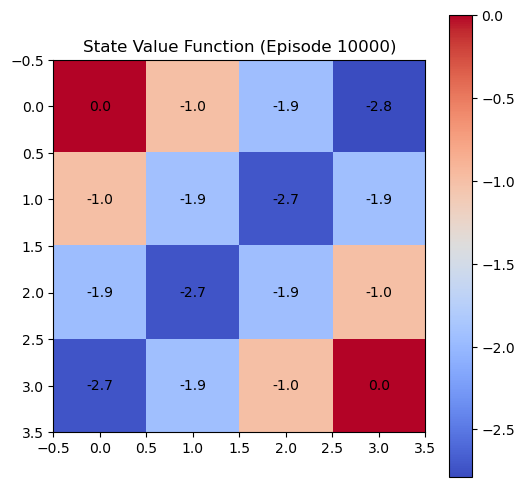

In [35]:
N = 10_000

env = GridWorld()

Q, history = sarsa(
    env=env,
    num_episodes=N, 
    gamma=0.9,
    alpha=0.015,
    lambda_=0.8,
    eps_start=0.05,#0.99,
    eps_decay=1#0.9995
)
plot_value_function(Q, env.size, N)

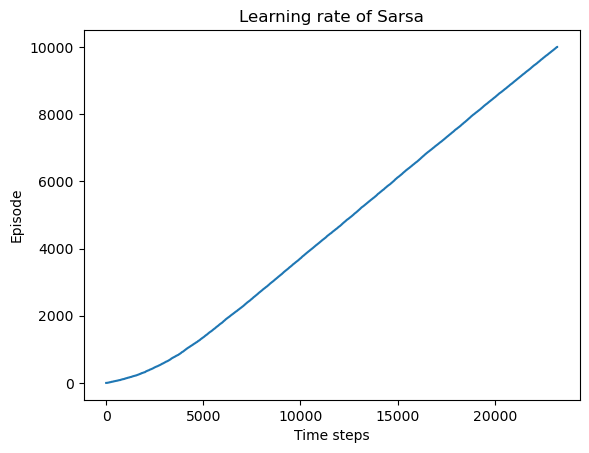

In [36]:
plt.plot(list(range(len(history))), history)
plt.title('Learning rate of Sarsa')
plt.xlabel('Time steps')
plt.ylabel('Episode')
plt.show()